# Land Use and Land Cover Classification using a ResNet Deep Learning Architecture 

## Prepare the development environment

In [ ]:
!pip install fastai==2.5.1

In [ ]:
import fastai
print(fastai.__version__)

2.5.1


## Download the EuroSAT RGB dataset
I download the EuroSAT RGB images from the DKFI website. The images are compressed in a zip file and divided in 10 folders named after the classes defined for the classification task

In [ ]:
from fastai.vision.all import *
path = untar_data('http://madm.dfki.de/files/sentinel/EuroSAT.zip')

In [ ]:
Path.BASE_PATH = path
path.ls()

(#10) [Path('Forest'),Path('HerbaceousVegetation'),Path('AnnualCrop'),Path('PermanentCrop'),Path('River'),Path('Industrial'),Path('Highway'),Path('Pasture'),Path('Residential'),Path('SeaLake')]

Let's see one image in the PermanentCrop folder

In [ ]:
fname = (path/"PermanentCrop").ls()[0]
fname

Path('PermanentCrop/PermanentCrop_1622.jpg')

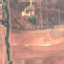

In [ ]:
img = Image.open(fname)
img

We can use regular expression to extract the label from the file name

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['PermanentCrop']

## Define the DataLoaders, the test and validation set, and the transformations to be applied


In [ ]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(seed=42),  # default random split 80% training, 20% validation
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

In [ ]:
dls = blocks.dataloaders(path)

We can check that the data loader is properly configured

In [ ]:
blocks.summary(path)

Setting-up type transforms pipelines
Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/EuroSAT/AnnualCrop/AnnualCrop_2377.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=64x64
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/EuroSAT/AnnualCrop/AnnualCrop_2377.jpg
    applying partial gives
      AnnualCrop
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=64x64, TensorCategory(0))


Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipe

We show some of the pictures in one batch with their labels (e.g. 5 images out of 64 contained in a batch)

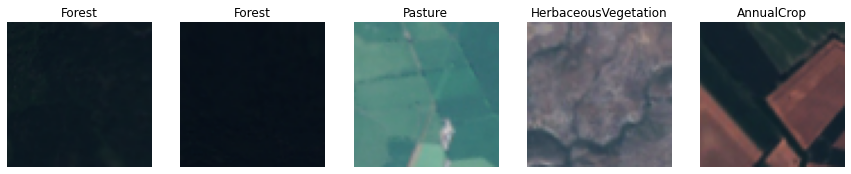

In [ ]:
dls.show_batch(nrows=1, ncols=5)

## Data augmentation
Additional images have been already created in the previous step from the original ones by using the data augmentation technique implemented by the fastai aug_transforms() convenience function. Here I show the images that are created from one example.

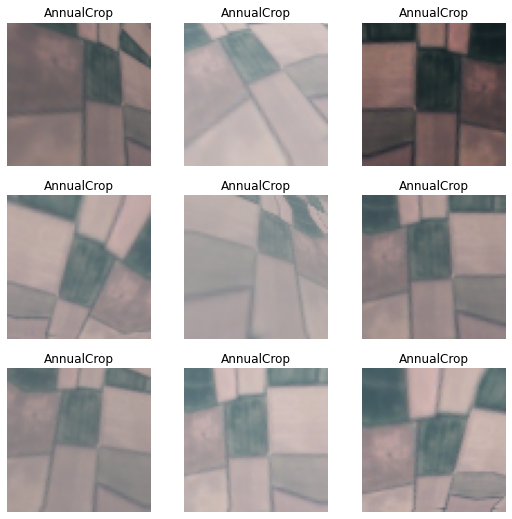

In [ ]:
blocks = blocks.new(batch_tfms=aug_transforms(mult=2.0))
dls = blocks.dataloaders(path)
dls.train.show_batch(nrows=3, unique=True)

## Setup the ResNet50 ConvNet pretrained architecture


In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy) 
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 16 x 16  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

## Finetuning


In [ ]:
learn.fine_tune(20)

We have achieved an accuracy close to 98%. The exact value can change slightly anytime we finetune the model. If that level of accuracy is enough for our purpose we can stop here otherwise we can run more epochs, try different learning rates or apply more transformations to further increase the number of images. We can plot the accuracy of the finetuned model relative to the number of epochs.

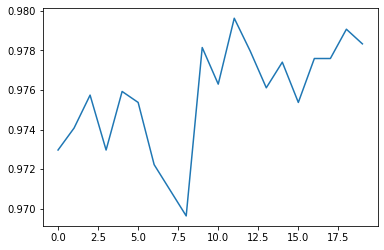

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

## Model evaluation


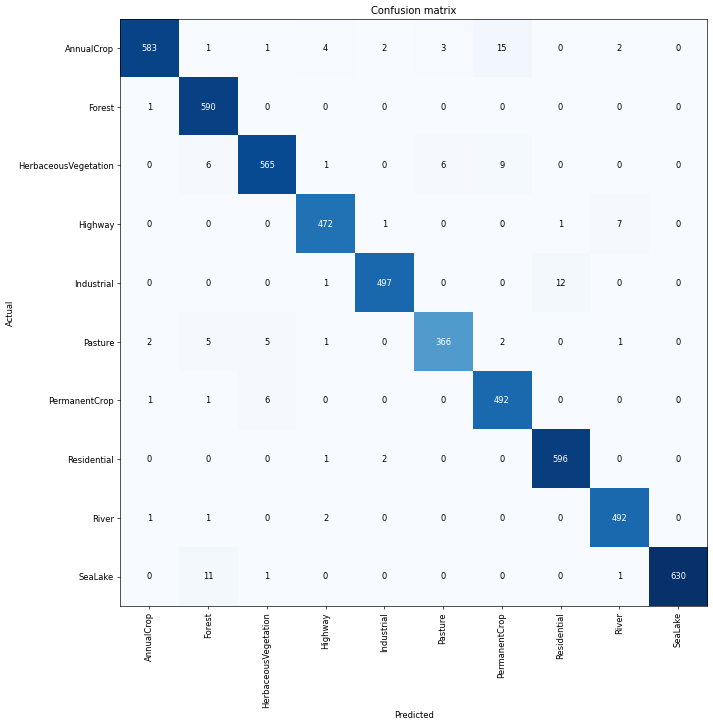

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can select the classes that have a minimum number of misclassifications

In [ ]:
interp.most_confused(min_val=5)

[('AnnualCrop', 'PermanentCrop', 15),
 ('Industrial', 'Residential', 12),
 ('SeaLake', 'Forest', 11),
 ('HerbaceousVegetation', 'PermanentCrop', 9),
 ('Highway', 'River', 7),
 ('HerbaceousVegetation', 'Forest', 6),
 ('HerbaceousVegetation', 'Pasture', 6),
 ('PermanentCrop', 'HerbaceousVegetation', 6),
 ('Pasture', 'Forest', 5),
 ('Pasture', 'HerbaceousVegetation', 5)]

As we already figured out, most of the misclassifications happen between classes that are related to the vegetation. Also for rivers and highways some misclassifications are reported. Still the great majority of classifications for each class are correct.

## Save and export the model's finetuned parameters
We can save the finetuned model parameters in case we want to use them in an application. 

In [ ]:
learn.export('eurosat_model.pkl')

In [ ]:
learn_inf = load_learner('eurosat_model.pkl')

## A minimalist application


The [1st image](images/sentinel-2/2019-07-16-Sentinel-2_L1C_Mesero.jpg) of the area was taken in July 2019 and shows a land that is mostly covered by crops ('Permanent Crop' or 'Annual Crop') but also contains a highway at its bottom.

In [ ]:
from fastai.vision.widgets import *
btn_upload1 = widgets.FileUpload()
btn_upload1

FileUpload(value={}, description='Upload')

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
img1 = PILImage.create(btn_upload1.data[-1])
with out_pl: display(img1)
out_pl

Output()

The probabilities computed by our model for the 1st image (I show only the two highest values) are:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img1)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Highway; Probability: 0.9980')

In [ ]:
probs

tensor([4.8410e-04, 1.3392e-06, 1.5634e-04, 9.9796e-01, 1.9808e-04, 1.3962e-04,
        8.8622e-04, 4.6300e-05, 1.1766e-04, 1.2730e-05])

The [2nd image](images/sentinel-2/2021-08-14-Sentinel-2_L1C_Mesero.jpg) was taken in August 2021 and shows an industrial building and still the same highway as in 2019.

In [ ]:
btn_upload2 = widgets.FileUpload()
btn_upload2

FileUpload(value={}, description='Upload')

In [ ]:
out_pl.clear_output()
img2 = PILImage.create(btn_upload2.data[-1])
with out_pl: display(img2)
out_pl

Output()

The probabilities for the 2nd image (2021) are:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img2)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Industrial; Probability: 0.7301')

In [ ]:
probs

tensor([2.8591e-04, 3.4131e-06, 1.4427e-04, 2.6680e-01, 7.3014e-01, 3.1067e-05,
        1.4392e-04, 3.6543e-04, 2.0304e-03, 5.0807e-05])

The model has been able to detect the change of land cover even if the presence of objects of two different classes, i.e. crop and highway in the 1st image and industrial building and highway in the 2nd image may have decreased the confidence of the model. If you use the model with the same hyperparameters and number of epoch you should see a similar result with some slightly difference in the probabilities.

## References
1. [He K. et al. - Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
2. [Helber P. et al. - EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://arxiv.org/abs/1709.00029) 
3. [Copernicus Land Monitoring Service - CORINE Land Cover User Manual](https://land.copernicus.eu/user-corner/technical-library/clc-product-user-manual)
